In [97]:
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split

# Create learning dataset

In [98]:
dataset = pd.read_csv("../data/ready_to_use_datasets/lesfresnes.csv")

In [99]:
dataset["date"] = pd.to_datetime(dataset["date"])

In [100]:
X = dataset.drop(["reference_pm25", "microsensor_pm25", "date", "monthofyear"], axis=1)

In [101]:
X

,hourofday,season,temperature,humidity
0,0,Winter,13.21,99.9
1,0,Winter,13.21,99.9
2,0,Winter,12.92,99.9
3,0,Winter,12.92,99.9
4,0,Winter,13.21,99.9
...,...,...,...,...
753065,13,Winter,7.20,99.9
753066,13,Winter,7.20,99.9
753067,13,Winter,7.61,99.9
753068,13,Winter,7.61,99.9


## Scale data

In [102]:
scaler = MinMaxScaler()
continuous_variables = ["temperature", "humidity"]
X[continuous_variables] = scaler.fit_transform(X[continuous_variables])

## One-hot encoding

In [103]:
hourofday_to_daytime = {
    0: "night",
    1: "night",
    2: "night",
    3: "night",
    4: "night",
    5: "night",
    6: "morning",
    7: "morning",
    8: "morning",
    9: "morning",
    10: "morning",
    11: "morning",
    12: "afternoon",
    13: "afternoon",
    14: "afternoon",
    15: "afternoon",
    16: "afternoon",
    17: "evening",
    18: "evening",
    19: "evening",
    20: "evening",
    21: "night",
    22: "night",
    23: "night"
}

X["daytime"] = X["hourofday"].map(hourofday_to_daytime)
X.drop(columns=["hourofday"], inplace=True)

In [104]:
categorical_variables = ["daytime", "season"]
X = pd.concat([X, pd.get_dummies(X[categorical_variables])], axis=1)

In [106]:
# Drop raw categorical variables
X.drop(columns=categorical_variables, inplace=True)
X

,temperature,humidity,daytime_afternoon,daytime_evening,daytime_morning,daytime_night,season_Autumn,season_Spring,season_Summer,season_Winter
0,0.304574,1.0,False,False,False,True,False,False,False,True
1,0.304574,1.0,False,False,False,True,False,False,False,True
2,0.298977,1.0,False,False,False,True,False,False,False,True
3,0.298977,1.0,False,False,False,True,False,False,False,True
4,0.304574,1.0,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
753065,0.188574,1.0,True,False,False,False,False,False,False,True
753066,0.188574,1.0,True,False,False,False,False,False,False,True
753067,0.196487,1.0,True,False,False,False,False,False,False,True
753068,0.196487,1.0,True,False,False,False,False,False,False,True


## Construct labels

A microsensor measure is labeled wrong if the absolute difference with the reference station exceeds an arbitrarily chosen threshold.

In [107]:
# Construct labels
threshold = 3
y = abs(dataset["reference_pm25"] - dataset["microsensor_pm25"]) >= threshold

## Split training and testing sets

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)

In [109]:
true_propor = sum(y_train) / len(y_train)
print(f"{round(true_propor * 100, 2)}% of the training measures are labeled as wrong.")

27.87% of the training measures are labeled as wrong.


In [110]:
balancer = SMOTE()
X_train, y_train = balancer.fit_resample(X_train, y_train)

In [111]:
true_propor = sum(y_train) / len(y_train)
print(
    f"{round(true_propor * 100, 2)}% of the training measures are labeled as wrong after the SMOTE resampling."
)

50.0% of the training measures are labeled as wrong after the SMOTE resampling.


# Logistic regression

## Train the model

In [112]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

## Analyse model

### Metrics

In [113]:
y_pred = model.predict(X_test)

In [114]:
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")

Precision: 0.404572583210163
Accuracy: 0.6656255975524252
Recall: 0.4099258781824041


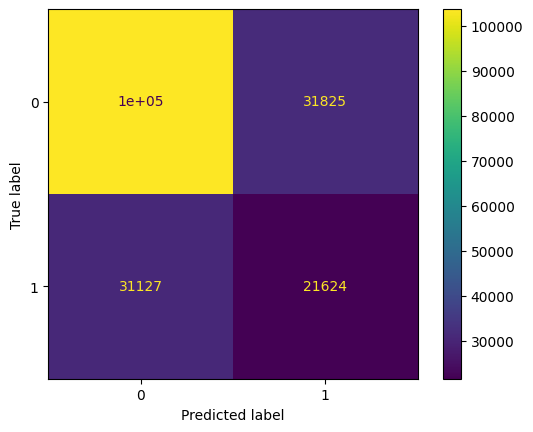

In [115]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [116]:
print(f"Proportion of predicted positive: {sum(y_pred) / len(y_pred)}")

Proportion of predicted positive: 0.28389848513820726


### Comparison with dummy classifier

In [117]:
dummy_model = DummyClassifier(strategy="uniform")
dummy_model.fit(X_test, y_test)
dummy_pred = dummy_model.predict(X_test)
print(f"Precision: {precision_score(y_test, dummy_pred)}")
print(f"Accuracy: {accuracy_score(y_test, dummy_pred)}")
print(f"Recall: {recall_score(y_test, dummy_pred)}")

Precision: 0.28072484845911316
Accuracy: 0.5003824335521703
Recall: 0.5012985535819227


### Feature importance

In [118]:
params = model.coef_.flatten()
print(params)

[ 0.54628652 -0.50693352 -0.22570882 -0.08335472  0.17137188  0.26132012
 -0.21828076 -0.23001799 -0.28833474  0.86026195]


In [119]:
# Get absolute values as feature importance
params = abs(params)

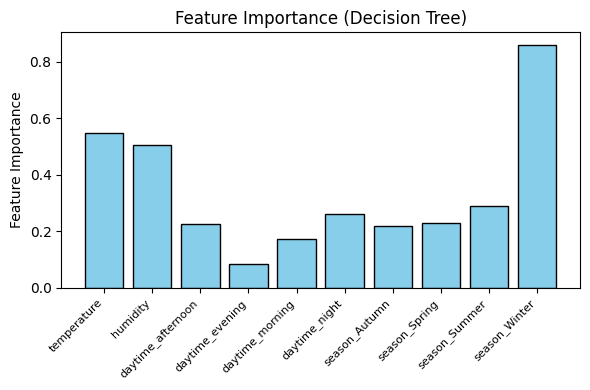

In [121]:
feature_names = X.columns

plt.figure(figsize=(6, 4))
plt.bar(
    range(len(params)),
    params,
    color="skyblue",
    edgecolor="black",
)
plt.xticks(
    range(len(feature_names)), feature_names, rotation=45, ha="right", fontsize=8
)
plt.ylabel("Feature Importance", fontsize=10)
plt.title("Feature Importance (Decision Tree)", fontsize=12)
plt.tight_layout()
plt.show()